<a href="https://colab.research.google.com/github/andrew-veriga/sunpower/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Получение данных из excel

In [1]:
import pandas as pd

# df = pd.read_csv("https://github.com/andrew-veriga/sunpower/raw/master/SES_1_Cherny_Yar_-_gotovo.csv", parse_dates=["Дата"], index_col="Дата")
df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_1_Cherny_Yar_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
df.head()


,№ п/п,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Общая облачность,"Текущая погода, сообщаемая с метеорологической станции",Прошедшая погода между сроками наблюдения 1,Прошедшая погода между сроками наблюдения 2,"Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака","Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm",Высота основания самых низких облаков (м),"Высококучевые, высокослоистые и слоисто-дождевые облака","Перистые, перисто-кучевые и перисто-слоистые облака",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,,,,,,,,,,
2019-04-25 01:00:00.000,1,01:00:00,0.000000,9.1,766.4,766.9,68.0,247.5,2,Облаков нет.,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
2019-04-25 04:00:00.000,2,04:00:00,0.147833,7.6,766.1,766.6,73.0,202.5,1,20–30%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",Облаков нет.,"2500 или более, или облаков нет.","Высококучевых, высокослоистых или слоисто-дожд...",Перистые когтевидные или нитевидные или первые...,10.0
2019-04-25 06:59:59.995,3,07:00:00,5.024833,6.5,766.2,766.7,82.0,270.0,1,"10% или менее, но не 0",,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...","10% или менее, но не 0","2500 или более, или облаков нет.","Высококучевые просвечивающие, полосами, либо о...","Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-25 09:59:59.995,4,10:00:00,11.363389,18.8,766.7,767.2,34.0,90.0,1,"10% или менее, но не 0",,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...","10% или менее, но не 0","2500 или более, или облаков нет.",Высококучевые башенкообразные или хлопьевидные.,"Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-25 12:59:59.995,5,13:00:00,10.962667,23.0,766.3,766.9,22.0,90.0,2,20–30%.,,NaN,NaN,"Кучевые плоские или кучевые разорванные, или т...","10% или менее, но не 0",1000-1500,"Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...",10.0


доступные колонки

In [2]:
df.columns

Index(['№ п/п', 'Время', 'Мощность, МВт',
       'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
       'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
       'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
       'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
       'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
       'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
       'Общая облачность',
       'Текущая погода, сообщаемая с метеорологической станции ',
       'Прошедшая погода между сроками наблюдения 1',
       'Прошедшая погода между сроками наблюдения 2',
       'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые обла

Создание набора данных из числовых колонок

In [3]:
series = df[
            [
            # 'Время',
            'Мощность, МВт',
            'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
            'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
            'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
            'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
            'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
            'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
            # 'Общая облачность',
            # 'Текущая погода, сообщаемая с метеорологической станции ',
            # 'Прошедшая погода между сроками наблюдения 1',
            # 'Прошедшая погода между сроками наблюдения 2',
            # 'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака',
            # 'Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm',
            # 'Высота основания самых низких облаков (м)',
            # 'Высококучевые, высокослоистые и слоисто-дождевые облака',
            # 'Перистые, перисто-кучевые и перисто-слоистые облака',
            'Горизонтальная дальность видимости (км)'
             ]].fillna(0)#.asfreq(None)
            
            
series.head()

,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,
2019-04-25 01:00:00.000,0.000000,9.1,766.4,766.9,68.0,247.5,2,10.0
2019-04-25 04:00:00.000,0.147833,7.6,766.1,766.6,73.0,202.5,1,10.0
2019-04-25 06:59:59.995,5.024833,6.5,766.2,766.7,82.0,270.0,1,10.0
2019-04-25 09:59:59.995,11.363389,18.8,766.7,767.2,34.0,90.0,1,10.0
2019-04-25 12:59:59.995,10.962667,23.0,766.3,766.9,22.0,90.0,2,10.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb31c13208>,
      dtype=object)

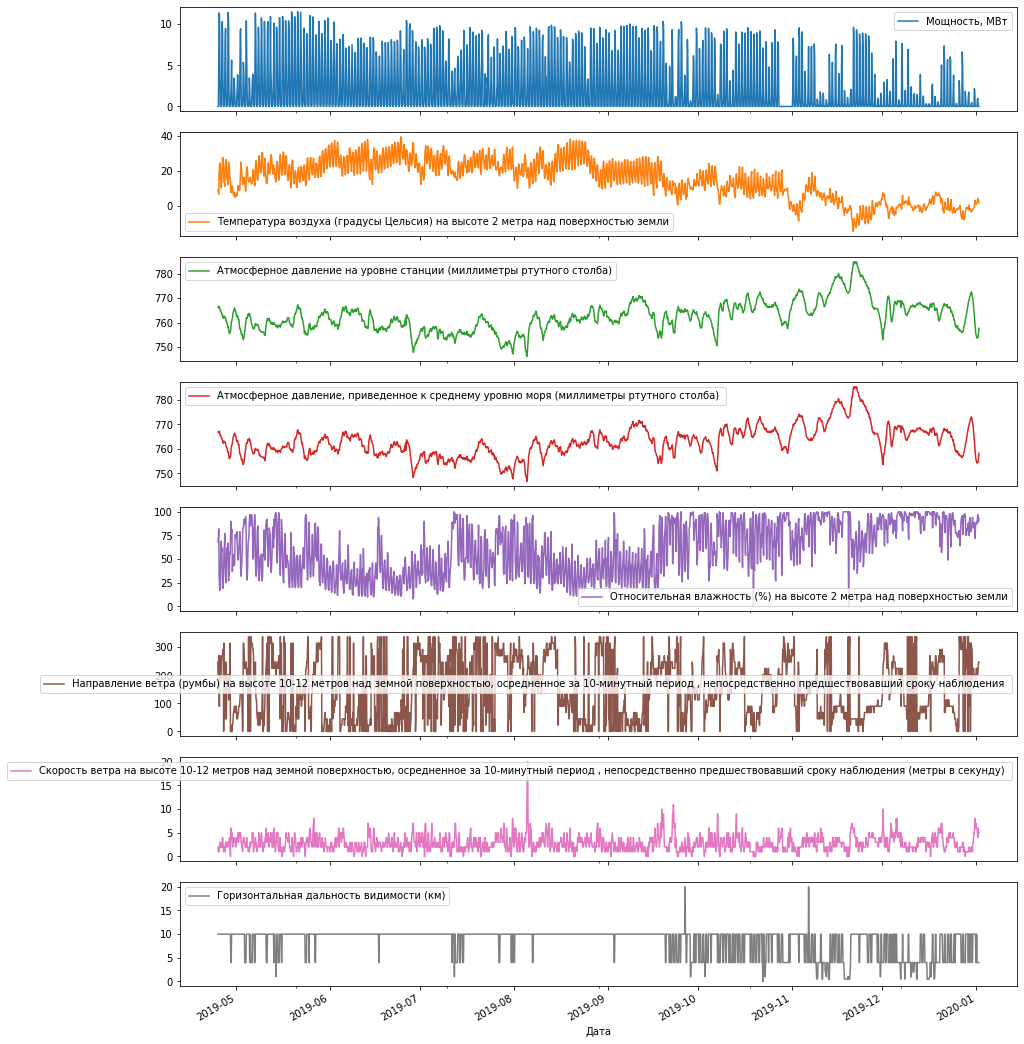

In [4]:
series.plot(subplots=True,figsize=(15,20))

###Создание датасета

In [0]:
split_datetime = 1500
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# data_mean = series[:split_datetime].mean(axis=0)
# data_std = series[:split_datetime].std(axis=0)

# series = (series-data_mean)/data_std

проба из https://www.tensorflow.org/tutorials/structured_data/time_series

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
######################################
past_history = window_size
future_target = 1
STEP = 1
ds= series.values
target = series['Мощность, МВт'].values
x_train_single, y_train_single = multivariate_data(ds, target, 0,
                                                   split_datetime, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

In [16]:
series.head()

,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,
2019-04-25 01:00:00.000,0.000000,9.1,766.4,766.9,68.0,247.5,2,10.0
2019-04-25 04:00:00.000,0.147833,7.6,766.1,766.6,73.0,202.5,1,10.0
2019-04-25 06:59:59.995,5.024833,6.5,766.2,766.7,82.0,270.0,1,10.0
2019-04-25 09:59:59.995,11.363389,18.8,766.7,767.2,34.0,90.0,1,10.0
2019-04-25 12:59:59.995,10.962667,23.0,766.3,766.9,22.0,90.0,2,10.0


In [0]:
import tensorflow as tf
import numpy as np
# target = series.pop('Мощность, МВт')

###Оформление оконного датасета

In [0]:

x_train = series[:split_datetime]
# y_train = target[:split_datetime]
x_valid = series[split_datetime:]
# y_valid = target[split_datetime:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, target, window_size, batch_size, shuffle_buffer):
  target_colnum=series.columns.get_loc(target)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1,target_colnum]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()

ds_train = windowed_dataset(x_train, 'Мощность, МВт', window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
ds_val_x = windowed_dataset(x_valid, 'Мощность, МВт', window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)


In [0]:
# target='Мощность, МВт'
# target_colnum=series.columns.get_loc(target)
# dataset = tf.data.Dataset.from_tensor_slices(series)
# dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
# dataset = dataset.map(lambda window: (window[:-1], window[-1,target_colnum]))
# iterator = dataset.as_numpy_iterator()# tf.compat.v1.data.Iterator.from_structure(ds_train.output_types,ds_train.output_shapes)
# X, y = iterator.next()
# print(y)
# print(series[target][:window_size+1])

In [96]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.LSTM(32, input_shape=(None, x_train.shape[1])),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
epoch_num=300
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
history = model.fit(ds_train, validation_data=(ds_val_x), epochs=epoch_num)#,callbacks=[lr_schedule])

Epoch 1/300

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 2s 127ms/step - loss: 12.0640 - mse: 12.1762 - val_loss: 5.8346 - val_mse: 5.8720
Epoch 2/300
12/12 [==============================] - 1s 45ms/step - loss: 11.4014 - mse: 11.4860 - val_loss: 6.1333 - val_mse: 6.1686
Epoch 3/300
12/12 [==============================] - 1s 45ms/step - loss: 11.3800 - mse: 11.4625 - val_loss: 6.2097 - val_mse: 6.2444
Epoch 4/300
12/12 [==============================] - 1s 45ms/step - loss: 11.3745 - mse: 11.4561 - val_lo

(1e-08, 0.1, 0.0, 20.0)

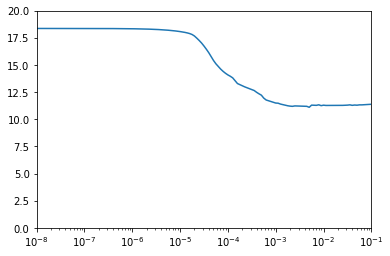

In [90]:
lrs = 1e-8 * (10 ** (np.arange(epoch_num) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 20])

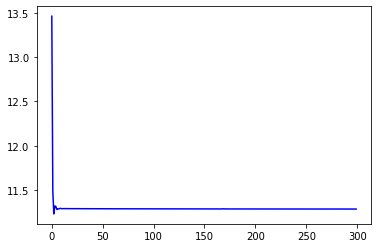

In [93]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[11.359240531921387, 11.357060432434082, 11.35567569732666, 11.35443115234375, 11.353267669677734, 11.35217571258545, 11.351147651672363, 11.350180625915527, 11.34926700592041, 11.348404884338379, 11.347591400146484, 11.346823692321777, 11.34609603881836, 11.34540843963623, 11.344754219055176, 11.344134330749512, 11.343544006347656, 11.342982292175293, 11.342445373535156, 11.341931343078613, 11.341439247131348, 11.34096622467041, 11.340511322021484, 11.340076446533203, 11.339656829833984, 11.339253425598145, 11.338866233825684, 11.33849048614502, 11.338130950927734, 11.337779998779297, 11.337440490722656, 11.337113380432129, 11.336796760559082, 11.3364896774292, 11.336190223693848, 11.335899353027344, 11.335616111755371, 11.335339546203613, 11.335071563720703, 11.334811210632324, 11.334553718566895, 11.334303855895996, 11.334060668945312, 11.333821296691895, 11.333586692810059, 11.333358764648438, 11.333133697509766, 11.33291244506836, 11.332695960998535, 11.33248519897461, 11.33227634

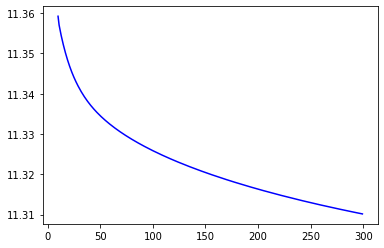

In [97]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

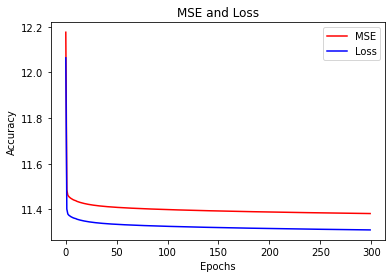

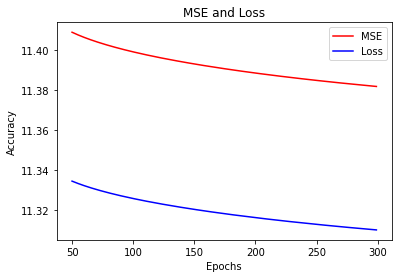

<Figure size 432x288 with 0 Axes>

In [98]:
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MSE and Loss
#------------------------------------------------
plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = mse[50:]
loss_zoom = loss[50:]

#------------------------------------------------
# Plot Zoomed MSE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

In [0]:
forecast=[]
for t in range(len(series) - window_size):
  pred=np.expand_dims(series[t:t+window_size],0)
  forecast.append(model.predict(pred).flatten())

results = forecast[split_datetime-window_size:]
results = np.array(results)#[:, 0, 0]




In [0]:
def plot_series(time, series, format="-", start=0, end=None, legend=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(legend)
    plt.grid(True)

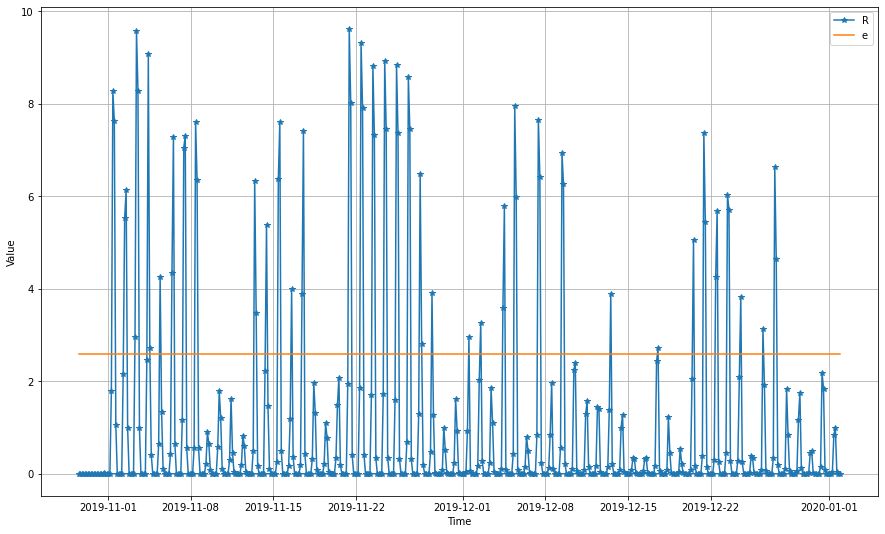

In [100]:
import matplotlib.pyplot as plt

time_train = x_valid.index.to_numpy(dtype=np.datetime64)
plt.figure(figsize=(15, 9))
# plt.legend(['res', 'power'])
plot_series(time_train, x_valid['Мощность, МВт'], format='-*', legend=['Power'])
plot_series(time_train, results,  legend='Result')